# Using OpenSBT with the CARLA Simulator

This notebook shows how to apply [OpenSBT](https://git.fortiss.org/opensbt/opensbt-core) in combination with the [CARLA](http://carla.org/) simulator. In the following example the system under test is provided as a collection of tool-independent black-box Functional Mock-up Units. 

To integrate the CARLA simulator we implement the Simulator class similiary as done with the DummySimulator for the Toy Example [here](https://git.fortiss.org/opensbt/opensbt-core/-/blob/main/docs/jupyter/02_Defining_Experiment.ipynb). The main difference is that we outsource the integration code in a seperate module [OpenSBT CARLA Runner](https://git.fortiss.org/opensbt/carla-runner) to achive a better maintainability of the code. The CARLA Runner manages the startup of the CARLA server, other dependent services and the excecution of scenarios passed by OpenSBT. This example should illustrate not only the modularity of the presented framework with respect to different simulators but to also showcase the interoperability of [OpenSBT CARLA Runner](https://git.fortiss.org/opensbt/carla-runner).

The [Functional Mock-up Interface (FMI) standard](https://fmi-standard.org) for exchanging dynamic simulation models is supported by a variety of commercial and open-source tools such as MATLAB, Dymola and OpenModelica (see [here](https://fmi-standard.org/tools/)).

<div class="alert alert-block alert-warning">

**REQUIREMENTS**

Before running this notebook, make sure that the computer on which it shall be executed meets the following requirements:

_Hardware_

| Component| Requirements |
| --- | --- |
| CPU | Quad-core Intel or AMD, 2.5 GHz or faster |
| GPU | NVIDIA GeForce 960 GTX or higher with 8 GB VRAM or more |
| RAM | 32 GB or more |

_Software_

* Ubuntu 20.04
* Python 3.8 with `pip` and `venv`
* Docker engine (see [here](https://docs.docker.com/engine/install/ubuntu/#install-using-the-repository)) with `sudo`-less access (see [here](https://docs.docker.com/engine/install/linux-postinstall/#manage-docker-as-a-non-root-user))
* NVIDIA Containter Toolkit (see [here](https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html#installation-guide))
* Internet access (for pulling Docker images and dependencies)

**NOTE:** Assuming this notebook is executed in a dedicated `venv` Python environment (as recommended for all tutorials), running it will not install any software on your system. Instead, all software will be executed within Docker containers (including the CARLA simulation).

</div>

<div class="alert alert-block alert-danger">

**NOTE:** Make sure to set the `DISPLAY` variable to the correct value for your setup! To check whether it is set correctly, open a terminal on the screen you would like your visualization to be displayed and run `echo $DISPLAY`, then update the assignment of the `$DISPLAY` variable in the fourth code cell (`In[4]`) accordingly.

</div>

## Problem Specification


In this example we consider a scenario where a pedestrian is crossing (perpendicularly) the lane of the ego vehicle. The scenario is specified by an OpenScenario file, see [here](https://git.fortiss.org/opensbt/opensbt-core/-/blob/main/examples/carla/scenarios/PedestrianCrossing.xosc) for one particular scenario instance. 

Given OpenSBTs modularity in the problem definition we can reuse the fitness/criticality function (line 13/14). 
The main difference in the definition is in line 6 and line 15. Here we pass the OpenSCENARIO file and the CARLA related Simulator class, namely our previously defined [CarlaSimulator](https://git.fortiss.org/opensbt/opensbt-core/-/blob/main/examples/carla/carla_simulation.py#L15). 

The parametrization of the scenario in the lines 7-12 specifies that the pedestrian speed (PedSpeed), the speed of the ego vehicle (EgoSpeed) and the distance to the ego vehicle when the pedestrian should start walking (PedDist) is to be modified to create new scenarios. The bounds in lines 7-8 are selected based on the requirements/capabilities of the systems/actors.

To apply a desired search technique we can pass in the experiment definition the algorithm (here NSGA-II) in line 23, without any additional problem specific modifications.


```python
from examples.carla.carla_simulation import CarlaSimulator
from opensbt.experiment.experiment import Experiment
from opensbt.algorithm.algorithm import AlgorithmType
from opensbt.experiment.search_configuration import DefaultSearchConfiguration
from opensbt.evaluation.fitness import FitnessMinDistanceVelocity
from opensbt.problem.adas_problem import ADASProblem
from opensbt.problem.pymoo_test_problem import PymooTestProblem
from opensbt.evaluation.critical import CriticalAdasDistanceVelocity

problem = ADASProblem(
                      problem_name="PedestrianCrossingStartWalk",
                      scenario_path=os.getcwd() + "/scenarios/PedestrianCrossing.xosc",
                      xl=[0.5, 1, 0],
                      xu=[3, 22, 60],
                      simulation_variables=[
                          "PedSpeed",
                          "EgoSpeed",
                          "PedDist"],
                      fitness_function=FitnessMinDistanceVelocity(),  
                      critical_function=CriticalAdasDistanceVelocity(),
                      simulate_function=CarlaSimulator.simulate,
                      simulation_time=10,
                      sampling_time=100,
                      approx_eval_time=10,
                      do_visualize = True
                      )
experiment = Experiment(name="1",
                        problem=problem,
                        algorithm=AlgorithmType.NSGAII,
                        search_configuration=DefaultSearchConfiguration())
```

We have already defined the presented experiment in OpenSBT. In the following section we will show how to execute this experiment.

## Search Execution

First, we need to clone the necessary repositories: OpenSBT, its CARLA Runner, the FMI orchestration engine ([ROSCo](https://git.fortiss.org/ff1/rosco)), but also CARLA's libraries:

In [ ]:
%%bash
export EXAMPLE_ROOT=$(pwd)/tmp

# Set up example folder.
mkdir -p $EXAMPLE_ROOT
cd $EXAMPLE_ROOT

# Fetch all necessary software.
git clone https://git.fortiss.org/opensbt/opensbt-core.git \
    $EXAMPLE_ROOT/opensbt/core
(cd $EXAMPLE_ROOT/opensbt/core; git reset --hard ca442043)
git clone https://git.fortiss.org/opensbt/carla-runner.git \
    $EXAMPLE_ROOT/opensbt/carla
(cd $EXAMPLE_ROOT/opensbt/carla; git reset --hard bb3f954a)
git clone https://git.fortiss.org/ff1/rosco.git \
    $EXAMPLE_ROOT/ff1/rosco
(cd $EXAMPLE_ROOT/ff1/rosco; git reset --hard 9dfda495)
git clone https://github.com/carla-simulator/carla.git \
    --depth 1 --branch 0.9.15 \
    $EXAMPLE_ROOT/carla/simulator
git clone https://github.com/carla-simulator/scenario_runner.git \
    --depth 1 --branch v0.9.15 \
    $EXAMPLE_ROOT/carla/runner

Next, we build and install all dependencies:

In [ ]:
%%bash
export EXAMPLE_ROOT=$(pwd)/tmp
cd $EXAMPLE_ROOT

# Update Python's pip package manger.
python -m pip install --upgrade pip

# Install all Python requirements.
python -m pip install -r $EXAMPLE_ROOT/opensbt/core/requirements.txt
python -m pip install --ignore-installed -r $EXAMPLE_ROOT/opensbt/carla/requirements.txt

# Build and install the CARLA runner.
cd $EXAMPLE_ROOT/opensbt/carla/
python -m build
python -m pip install --ignore-installed --force-reinstall dist/*.whl

At this point, the framework is set up and ready to be applied to a system under test. In this case we fetch the Functional Mock-up Units (FMUs) providing the executable behaviour of the various subsystems as well as the configuration files encoding the communication infrastructure among these subsystems from the OpenSBT examples and load them into the respective folders of our FMI orchestration engine:

In [ ]:
%%bash
export EXAMPLE_ROOT=$(pwd)/tmp
cd $EXAMPLE_ROOT

# Load a system under test.
git clone https://git.fortiss.org/opensbt/sut-examples.git \
    --depth 1 \
    $EXAMPLE_ROOT/opensbt/examples
rm -r $EXAMPLE_ROOT/ff1/rosco/launch/* $EXAMPLE_ROOT/ff1/rosco/share/*
cp $EXAMPLE_ROOT/opensbt/examples/rover/rosco/launch/* $EXAMPLE_ROOT/ff1/rosco/launch
cp $EXAMPLE_ROOT/opensbt/examples/rover/rosco/share/* $EXAMPLE_ROOT/ff1/rosco/share

We can now start the testing campaign. The environment variables tell OpenSBT, and CARLA where to find their dependencies:

<div class="alert alert-block alert-info">

**NOTE:** The first execution can take up to 15 minutes to fetch and build the whole testing infrastrcture before any test cases are executed.

</div>

<div class="alert alert-block alert-info">

**NOTE:** Due to a limitation of running the example in a Juypter notebook, the following cell won't terminate on it's own. To continue with the visualization of the result after the testing campaign has completed, stop the cell's execution manually. To do so safety, wait until the execution stops with an equivalent message:

```
2023-10-20 16:23:02,444 INFO     =====[NSGA2] Writing results to: 
2023-10-20 16:23:02,444 INFO     /home/user/Desktop/Jupyter/tmp/opensbt/core/results/PedestrianCrossingStartWalk/NSGA2/20-10-2023_16-23-02/
2023-10-20 16:23:13,360 INFO     ====== Algorithm search time: 6994.29 sec
```

</div>

In [ ]:
%%bash
export EXAMPLE_ROOT=$(pwd)/tmp
cd $EXAMPLE_ROOT

# Set all variables used by OpenSBT and CARLA.
export DISPLAY=:1
export OPENSBT_CORE_PATH=$EXAMPLE_ROOT/opensbt/core
export OPENSBT_RUNNER_PATH=$EXAMPLE_ROOT/opensbt/carla
export ROSCO_PATH=$EXAMPLE_ROOT/ff1/rosco
export SHARE_PATH=$EXAMPLE_ROOT/ff1/rosco/share
export CARLA_PATH=$EXAMPLE_ROOT/carla/simulator
export SCENARIORUNNER_PATH=$EXAMPLE_ROOT/carla/runner

# Update the PYTHONPATH to include all software.
export PYTHONPATH=$PYTHONPATH:$CARLA_PATH/PythonAPI/carla/agents
export PYTHONPATH=$PYTHONPATH:$CARLA_PATH/PythonAPI/carla
export PYTHONPATH=$PYTHONPATH:$SCENARIORUNNER_PATH

# Run one of the default experiments defined in OpenSBT using the CARLA.
cd $EXAMPLE_ROOT/opensbt/core/
python run.py -e 1 -n 5 -i 5 -v

Once the images are pulled, the containers built, and the experiment started, a visualization similar to this one will pop up for each scenario instance:

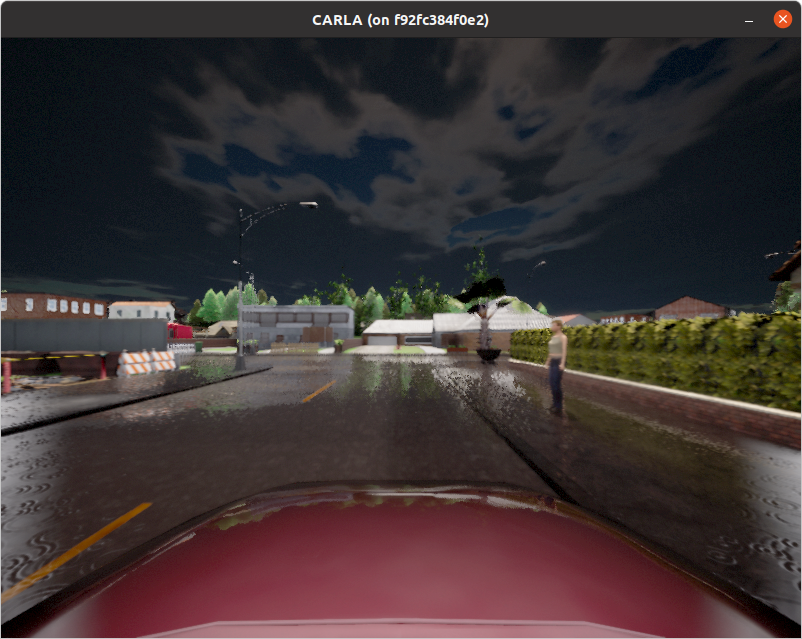

We can then inspect the search results. Below we see the visualization of critical test cases in the test input space for the dimensions pedestrian distance (PedDist) and pedestrian speed (PedSpeed). 

_Note, that given the systems performance/the search time there might be no critical test cases found._

In [ ]:
from os import listdir
from random import choice
from IPython.display import Image

RESULTS_DIR = "tmp/opensbt/core/results"

# As we have executed only one experiment, we can access it randomly.
by_scenario = "{}/{}".format(RESULTS_DIR, choice(listdir(RESULTS_DIR)))
by_algorithm = "{}/{}".format(by_scenario, choice(listdir(by_scenario)))
by_time = "{}/{}".format(by_algorithm, choice(listdir(by_algorithm)))

Image(filename="{}/design_space/PedSpeed_PedDist.png".format(by_time))